## Ni Sample 2 layers

In [1]:
import sys
import numpy as np
import scipy.interpolate as si
import os
import scipy.optimize
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, expanduser
#print(os.path.expanduser('~')) 
home = os.path.expanduser('~')

sys.path.append('../')
#sys.path.append(join(home,'Projects/helpfullscripts/'))
#import forJCM
#import geo_3 as geometry
import jcm_plotting_utils as JCMgrid

jcm_root = join(home,'JCMwave/JCMsuite_6_2_1/ThirdPartySupport/Python')
jcm_root = join(home,'JCMwave/JCMsuite_6_0_10/ThirdPartySupport/Python')
sys.path.append(jcm_root)
import jcmwave




#sys.path.append(join(home,'github/XRR_workflows/calculate_n_k_from_xrr'))
#sys.path.append(join(home,'Projects/XRR_workflows/calculate_n_k_from_xrr'))
import xray_compounds as xc
import pint
unit = pint.UnitRegistry()

#import pythia.Misc as MISC

#from paramiko import SSHClient

#import json

#import pandas as pd

#import pickle 

#import xraylib

import time

In [2]:
import scipy.constants
c = scipy.constants.c #speed of light
h = scipy.constants.h #Planck
e = scipy.constants.e #elemetry charge
hc = h*c/e*1e9 #wavelenght in nm
print(hc)
def eVnm_converter(value):
    #Planck's constant (6.6261 x 10-34 J*s) and c is the speed of light (2.9979 x 108 m/s)
    return hc/value

#E (eV) = 1239.8 / l (nm)     (equation 2) 

1239.8419843320025


In [3]:
jcmwave.daemon.shutdown()
jcmwave.daemon.add_workstation(
        Hostname='localhost',
        #Login='andrle01',
        JCMROOT=jcm_root,
        Multiplicity=2,
        NThreads=12
        )

#jcmwave.set_memory_limit(max_ram=25000)
#ssh = SSHClient()
#ssh.load_system_host_keys()
#ssh.connect('aidos')
#ssh_stdin, ssh_stdout, ssh_stderr = ssh.exec_command('renice 5 -u andrle01')

[512458677, 1740103743]

In [4]:
keys = {
    'fem_deg': 4,  # degree Polynom for fitting
    'uol1': 1e-9,  # einheit in nm
    'uol': 1,
    'energy_list':np.array([280,285]), #eV
}

In [5]:
#Get optical constants from Henke and periodictable
keys['Ni_density'] = 6.5
keys['NiO2_density'] = 5


nk_Ni = np.conjugate(xc.refractive_index('Ni', keys['energy_list'] * unit.eV, density=6.5))
nk_NiO = np.conjugate(xc.refractive_index('NiO', keys['energy_list'] * unit.eV, density=5))


nk_Si3N4 = np.conjugate(xc.refractive_index('Si3N4', keys['energy_list'] * unit.eV, density=2.8))
nk_H2O = np.conjugate(xc.refractive_index('H2O', keys['energy_list'] * unit.eV, density=1))

keys['nk_Ni'] = nk_Ni
keys['nk_NiO2'] = nk_NiO
keys['nk_Si3N4'] = nk_Si3N4
keys['nk_H2O'] = nk_H2O

In [29]:


i_taken_energy = -1
energy =  keys['energy_list'] * unit.eV
wl = energy.to(unit.nm, 'sp').magnitude
keys['energy'] = energy[i_taken_energy].to(unit.keV, 'sp').magnitude
keys['pol'] = [1, 0] #1,0 s pol 0,1 p pol
keys['lambda'] = wl[i_taken_energy] * 1e-9

#tensor = eye

keys['nk'] = [ 1 + 0 * 1j, #vacuum
              nk_NiO[i_taken_energy]*np.eye(3,3), #oxide layer
              nk_Ni[i_taken_energy], #material of the grating
               nk_Si3N4[i_taken_energy], #nk_Si3N4, #layer on top of the substrate
               nk_H2O[i_taken_energy], #1 + 0 * 1j #nk_H2O[0], #1 + 0 * 1j #substrate nk_Si
              1 + 0 * 1j, #cont_layer
             ]

keys['permittivity_1'] = nk_Ni[i_taken_energy]**2
keys['permittivity_2'] = nk_NiO[i_taken_energy]**2
keys['exponent_g'] = 1
keys['max_a'] = 1


keys['name_domain'] = ['vacuum','oxide layer','grating','layer','substrate','cont']
keys_geo ={
    'pitch':10,
    'height':50,
    #'cd':100,
    #'swa':90,
    #'thickness_oxid_etch_offset':0,
    'thickness_oxid':3,
    'thickness_oxid_Si_Si3N4': 50,
    'height_offset_substrate':8,
    'height_offset_air':5,
    'height_C':5,
    'R':0
    }

keys.update(keys_geo)

p2 = keys['pitch']/2

height_cell = keys['height']+keys['height_C']+keys['thickness_oxid'] + keys['height_offset_air']

keys['points_cd'] = [-p2,-keys['height_offset_substrate']-keys['thickness_oxid_Si_Si3N4'],p2,-keys['height_offset_substrate']-keys['thickness_oxid_Si_Si3N4'],p2,height_cell,-p2,height_cell]
keys['points_substrate'] = [-p2,-keys['height_offset_substrate']-keys['thickness_oxid_Si_Si3N4'],p2,-keys['height_offset_substrate']-keys['thickness_oxid_Si_Si3N4'],p2,-keys['thickness_oxid_Si_Si3N4'],-p2,-keys['thickness_oxid_Si_Si3N4']]
keys["points_to_Si_Si3N4"] = [-p2,-keys['thickness_oxid_Si_Si3N4'],p2,-keys['thickness_oxid_Si_Si3N4'],p2,0,-p2,0]
keys['points_line_komplet'] = [-p2,0,p2,0,p2,keys['height'],-p2,keys['height']]
keys['points_oxid_komplet'] = [-p2-keys['max_a'],0,p2+keys['max_a'],0,p2+keys['max_a'],keys['height'] + keys['thickness_oxid'],-p2-keys['max_a'],keys['height'] + keys['thickness_oxid']]
keys['points_cont_komplet'] = [-p2,0,p2,0,p2,keys['height'] + keys['thickness_oxid'] + keys['height_C'],-p2,keys['height'] + keys['thickness_oxid'] +keys['height_C']]



#angles = np.linspace(-120,-90,51)
keys['Theta_unique'] = np.array([10,45,90])


keys['slc'] = 0.7 #0.5
keys['fem_deg'] = 5




Text(0, 0.5, 'Y / nm')

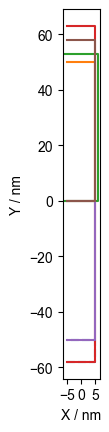

In [22]:

plt.axes().set_aspect('equal')
plt.plot(keys['points_substrate'][::2],keys['points_substrate'][1::2],'--')
plt.plot(keys['points_line_komplet'][::2],keys['points_line_komplet'][1::2],'-')
plt.plot(keys['points_oxid_komplet'][::2],keys['points_oxid_komplet'][1::2])
plt.plot(keys['points_cd'][::2],keys['points_cd'][1::2])
plt.plot(keys['points_to_Si_Si3N4'][::2],keys['points_to_Si_Si3N4'][1::2])
plt.plot(keys['points_cont_komplet'][::2],keys['points_cont_komplet'][1::2])
plt.xlabel('X / nm')
plt.ylabel('Y / nm')

(0.980377561737373+0.009067686445801054j)
(0.9837980136214858+0.0059044683740461j)


/tmp/ipykernel_2654389/1082912484.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
  grid_z[ii][jj]=value #np.min(d_array)


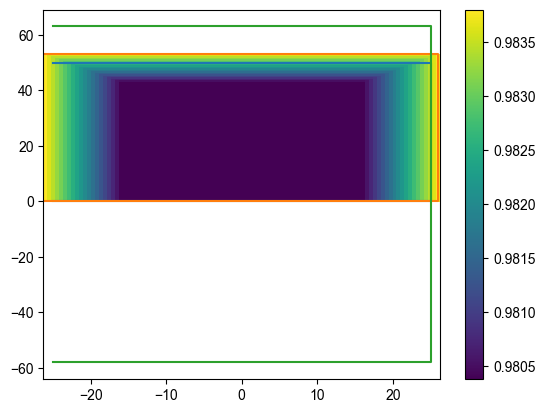

In [19]:
x_linspace = np.linspace(-100,100,100)
y_linspace = np.linspace(np.min(keys['points_cd'][1::2]),np.max(keys['points_cd'][1::2]),100)
xy_mesh =  np.meshgrid(x_linspace,y_linspace)
np.shape(xy_mesh)
grid_z = xy_mesh[0].copy()*0+1

ax = keys['points_oxid_komplet'][::2]
ay = keys['points_oxid_komplet'][1::2]

x_linspace = np.linspace(np.min(ax),np.max(ax),100)
y_linspace = np.linspace(np.min(ay),np.max(ay),100)
xy_mesh =  np.meshgrid(x_linspace,y_linspace)

max_a = 10
g = 1
n1 = keys['permittivity_1'] 
n2 = keys['permittivity_2'] 
grid_z = (xy_mesh[0].copy()*0)+60
print(n1)
print(n2)

def abstand(x,y,x1, y1, x2,y2):
    x1x2=x1-x2
    y1y2=y1-y2
    #abs_richtung=power(power(x1x2,2)+power(y1y2,2),0.5);
    abs_richtung=np.sqrt(np.square(x1x2)+np.square(y1y2))
    #d = power(power((x-x1)*y1y2-(y-y1)*x1x2,2),0.5)/abs_richtung;
    d = np.sqrt(np.square((x-x1)*y1y2-(y-y1)*x1x2))/abs_richtung
    lam = ((x1-x)*x1x2+(y1-y)*y1y2)/((-1)*(x1x2*x1x2)+(y1y2*y1y2))
    #d_ecke = power((power(x-x1,2)+power(y-y1,2)),0.5)
    d_ecke = np.sqrt((np.square(x-x1)+np.square(y-y1)))
    if abs(y1y2)<5e-9:
        lam=lam*(-1)
    return d, lam, d_ecke

def distance(X,X1,X2):
    orientation_norm = np.linalg.norm(X2-X1)
    cross_product_norm =  np.linalg.norm(np.cross((X-X1),X2))
    d = cross_product_norm/orientation_norm
    return d
                        
#d = max_a##
for ii in range(np.shape(grid_z)[0]):
    for jj in range(np.shape(grid_z)[1]):
        X = [xy_mesh[0][ii][jj],xy_mesh[1][ii][jj]]
        #d = max_a
        d_array = []
        for i in range(np.shape(ax)[0]):
            if i>=1 and i < np.shape(ax)[0]:
                a=i
                b=i+1
    
                if i==np.shape(ax)[0]-1:
                    b=0
        
                #if ax[b] <= X[0] <= ax[a]:
                    #print(X,ax[a],ax[b])
                #    if ay[a] <= X[1] <= ay[b]:
                #X1 = np.array([ax[a],ay[a]])
                #X2 = np.array([ax[b],ay[b]])
                    #d_temp = distance(X,X1,X2)
                    #print(d_temp)
                d_temp, lam, d_ecke  =abstand(X[0],X[1],ax[a],ay[a],ax[b],ay[b])
                d_array.append(d_temp)
        
        #for i in range(np.shape(points_oxid_x)[0]):
        #    if i>1 and i < np.shape(points_oxid_x)[0]-1:
        #        d_temp, lam, d_ecke=abstand(X[0],X[1],points_oxid_x[i],points_oxid_y[i],points_oxid_x[i+1],points_oxid_y[i+1])
            #print(np.shape(d_temp))
                #if d_temp < d and 0<=lam <= 1:
                #    d = d_temp.copy()
                #elif d_ecke<d:
                #    d = d_ecke.copy()
                   
                d = np.min(d_array)
                if d<max_a:
                    value= n1+(n2-n1)*(1-np.power(d/max_a,g))
                else:
                    value= n1
                grid_z[ii][jj]=value #np.min(d_array)
plt.pcolormesh(xy_mesh[0],xy_mesh[1],np.real(grid_z))
plt.plot(keys['points_line_komplet'][::2],keys['points_line_komplet'][1::2],'-')
plt.plot(keys['points_oxid_komplet'][::2],keys['points_oxid_komplet'][1::2])
plt.plot(keys['points_cd'][::2],keys['points_cd'][1::2])
plt.colorbar()

KeyError: np.uint64(7)

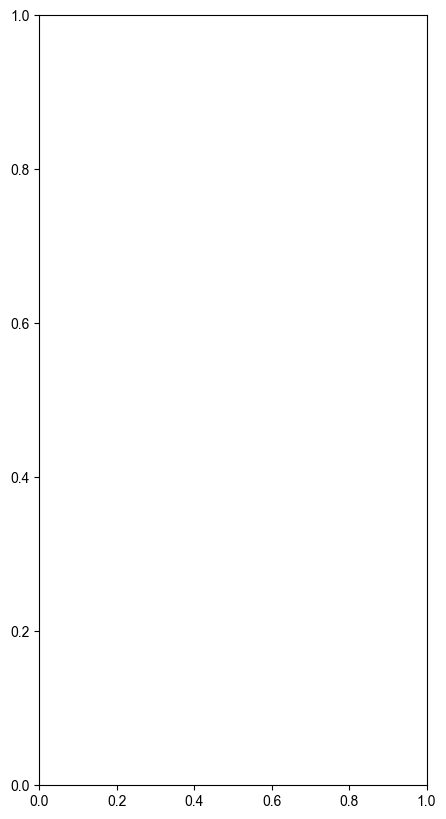

In [23]:
keys['slc'] = 1
jcmwave.geo('./_JCM_clean_gradient/', keys=keys )
figure,ax1 =plt.subplots(1,1, figsize=(5,10))
JCMgrid.plot_grid('./_JCM_clean_gradient/grid.jcm', ax= ax1 , colors = {1: 'white', 2:'green', 3: 'black', 4:'blue', 5:'orange', 6:'pink'}, alpha= 0.5 , lw = 0.2)
#jcmwave.view('./_JCMupdate/grid.jcm')
plt.xlim(-keys['pitch']/2,keys['pitch']/2)
plt.ylim(np.min(keys['points_cd'][1::2]),np.max(keys['points_cd'][1::2]))
ax1.set_aspect('equal')
plt.xlabel('X / nm')
plt.ylabel('Y / nm')
#figure.savefig('mesh_Ni_01.png',dpi=200)

In [32]:
keys['angle_of_incidence'] = 90-keys['Theta_unique'][0] #keys['angles'][10][0] #90-keys['angles'][0][0]+keys['aoi_offset'] +180
#print(Theta_unique[30])

keys['phi'] = 90 #90 +keys['angles'][0][1]+keys['phi_offset']  #
keys['slc'] = 3
#keys['fem_deg'] = 4

#jcmwave.daemon.shutdown()
job_ids = jcmwave.solve('./_JCM_clean_gradient/project-field.jcmpt',  keys=keys)
#job_ids = jcmwave.solve('./_JCM_clean_gradient/project.jcmpt',  keys=keys)
#start = time.time()
results, logs = jcmwave.daemon.wait(job_ids,verbose=False)
#end = time.time()
#print(end - start)


In [20]:
print(logs)

[{'ExitCode': 0, 'Log': {'Error': '', 'Out': '\n\n\n*** Solving /home/kas/Projects/IntroJCMwave/_JCM_clean/project-field.jcmp on refinement level 0 ... \n\nA priori segments/wavelength (quality = 1.00e-02)\n  FEM degree  direction X  direction Y\n-------------------------------------------------\n           1          inf          inf\n           2        13.79        13.79\n           3         4.60         4.60\n           4         2.43         2.43\n           5         1.61         1.61\n           6         1.19         1.19\n           7         0.93         0.93\n           8         0.76         0.76\n           9         0.64         0.64\n          10         0.55         0.55\n  minimum seg/wavelength in grid : 6.44\n  maximum seg/wavelength in grid : 15.40\n\n  *** A priori interior domain wave propagation characteristics (vacuum wavelength = 4.350 nm):\n  \n       Compartment "Y":\n    computational domain size:   32 (wavelengths).\n    computational domain range wave pro

In [20]:
results

[[{'file': '/home/kas/Projects/IntroJCMwave/Reflectivity/_JCM_clean_gradient/project-field_results/fieldbag.jcm',
   'computational_costs': {'title': 'ComputationalCosts',
    'header': {'AccumulatedCPUTime': 47.725301,
     'AccumulatedTotalTime': 10.982312666},
    'Level': array([0], dtype=int32),
    'Unknowns': array([503360], dtype=int32),
    'CpuTime': array([46.290768]),
    'CpuPerUnknown': array([9.1963541e-05]),
    'TotalTime': array([10], dtype=int32),
    'SystemMemory_GB': array([1.24547577]),
    'MaxNodeSystemMemory_GB': array([1.24547577]),
    'TotalMemory_GB': array([1.76073837]),
    'MaxNodeTotalMemory_GB': array([1.76073837]),
    'CpuTimeAssembling': array([31.355419]),
    'CpuTimeSolve': array([6.969426]),
    'CpuTimeInnerNodeUpdate': array([4.966362]),
    'TotalTimeAssembling': array([4.19055107]),
    'TotalTimeSolve': array([1.87213989]),
    'TotalTimeInnerNodeUpdate': array([2.76820305]),
    'FEDegree0_Percentage': array([0.]),
    'FEDegree1_Percenta

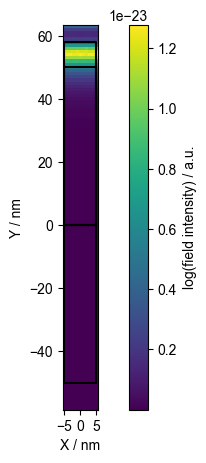

In [33]:
#jcmwave.view('./_JCMupdate/project_results/fieldbag.jcm')
result = results[0]
index_take = 1
amplitude = result[index_take]['field'][0]
intensity = (amplitude.conj()*amplitude).sum(2).real 


#intensity = np.absolute(result[4]['field'][0])

#np.shape(result[4]['X'])
np.shape(intensity)
#intensity
figure,ax1 =plt.subplots(1,1, figsize=(8,5))
plt.pcolormesh(result[index_take]['X']*1e9,result[index_take]['Y']*1e9,(intensity))
plt.xlabel('X / nm')
plt.ylabel('Y / nm')
ax1.set_aspect('equal')
plt.colorbar(label='log(field intensity) / a.u.')

x_line = np.append(keys['points_line_komplet'][::2],keys['points_line_komplet'][0])
y_line = np.append(keys['points_line_komplet'][1::2],keys['points_line_komplet'][1])
x_oxide = np.append(keys['points_cont_komplet'][::2],keys['points_cont_komplet'][0])
y_oxide = np.append(keys['points_cont_komplet'][1::2],keys['points_cont_komplet'][1])
x_mem = np.append(keys['points_to_Si_Si3N4'][::2],keys['points_to_Si_Si3N4'][0])
y_mem = np.append(keys['points_to_Si_Si3N4'][1::2],keys['points_to_Si_Si3N4'][1])
plt.plot(x_line,y_line,'k-')
plt.plot(x_oxide,y_oxide,'k-')
plt.plot(x_mem,y_mem,'k-')
#figure.savefig('field_distribution_Ni_01.png',dpi=200)

(-500000000.0, 500000000.0)

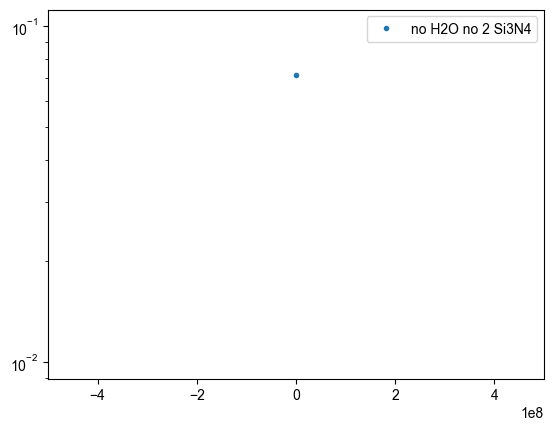

In [31]:
Kx = results[0][-1]['K'][:,0]
amplitude_x = results[0][-1]['ElectricFieldStrength'][0][:,0]
amplitude_y = results[0][-1]['ElectricFieldStrength'][0][:,1]
amplitude_z = results[0][-1]['ElectricFieldStrength'][0][:,2]
intensity_no2Si4N4 = (amplitude_x.conj()*amplitude_x).real +(amplitude_y.conj()*amplitude_y).real +(amplitude_z.conj()*amplitude_z).real 

#plt.plot(Kx,intensity,'.',label='complete cell')
#plt.plot(Kx,intensity_noH2O,'.',label='no H2O')
#plt.plot(Kx,intensity_no2Si4N4,'.',label='no 2 Si3N4')
plt.plot(Kx,intensity_no2Si4N4,'.',label='no H2O no 2 Si3N4')
plt.legend()
plt.yscale('log')
plt.xlim(-0.5e9,0.5e9)